# Reference original numpy simulation code 

From https://github.com/dandrino/terrain-erosion-3-ways/blob/master/simulation.py

In [1]:
import time

import matplotlib.pyplot as plt
from numpy_terrainer import *
from tqdm.notebook import tqdm

In [2]:
# Grid dimension constants
full_width = 200
dim = 1009
shape = [dim] * 2
cell_width = full_width / dim
cell_area = cell_width**2

In [3]:
# Water-related constants
rain_rate = 0.0008 * cell_area
evaporation_rate = 0.0005

# Slope constants
min_height_delta = 0.05
repose_slope = 0.03
gravity = 30.0
gradient_sigma = 0.5

# Sediment constants
sediment_capacity_constant = 50.0
dissolving_rate = 0.25
deposition_rate = 0.001

# The numer of iterations is proportional to the grid dimension. This is to
# allow changes on one side of the grid to affect the other side.
iterations = int(1.4 * dim)

In [4]:
terrain = fbm(shape, -2.0)

# `sediment` is the amount of suspended "dirt" in the water. Terrain will be
# transfered to/from sediment depending on a number of different factors.
sediment = np.zeros_like(terrain)

# The amount of water. Responsible for carrying sediment.
water = np.zeros_like(terrain)

# The water velocity.
velocity = np.zeros_like(terrain)

start_time = time.time()
for i in tqdm(range(0, iterations)):
    # Add precipitation. This is done by via simple uniform random distribution,
    # although other models use a raindrop model
    water += np.random.rand(*shape) * rain_rate

    # Compute the normalized gradient of the terrain height to determine where
    # water and sediment will be moving.
    # gradient = np.zeros_like(terrain, dtype="complex")
    gradient = simple_gradient(terrain)
    gradient = np.select(
        [np.abs(gradient) < 1e-10],
        [np.exp(2j * np.pi * np.random.rand(*shape))],
        gradient,
    )
    gradient /= np.abs(gradient)

    # Compute the difference between teh current height the height offset by
    # `gradient`.
    neighbor_height = sample(terrain, -gradient)
    height_delta = terrain - neighbor_height

    # The sediment capacity represents how much sediment can be suspended in
    # water. If the sediment exceeds the quantity, then it is deposited,
    # otherwise terrain is eroded.
    sediment_capacity = (
        (np.maximum(height_delta, min_height_delta) / cell_width)
        * velocity
        * water
        * sediment_capacity_constant
    )
    deposited_sediment = np.select(
        [
            height_delta < 0,
            sediment > sediment_capacity,
        ],
        [
            np.minimum(height_delta, sediment),
            deposition_rate * (sediment - sediment_capacity),
        ],
        # If sediment <= sediment_capacity
        dissolving_rate * (sediment - sediment_capacity),
    )

    # Don't erode more sediment than the current terrain height.
    deposited_sediment = np.maximum(-height_delta, deposited_sediment)

    # Update terrain and sediment quantities.
    sediment -= deposited_sediment
    terrain += deposited_sediment
    sediment = displace(sediment, gradient)
    water = displace(water, gradient)

    # Smooth out steep slopes.
    terrain = apply_slippage(terrain, repose_slope, cell_width)

    # Update velocity
    velocity = gravity * height_delta / cell_width

    # Apply evaporation
    water *= 1 - evaporation_rate
end_time = time.time()

print(f"Processing completed in: {(end_time - start_time):.3f} seconds")

  0%|          | 0/1412 [00:00<?, ?it/s]

Processing completed in: 440.026 seconds


In [5]:
def save_terrain_as_raw(terrain, filename):
    # Normalize the terrain to the range [0, 65535] for 16-bit
    min_val = np.min(terrain)
    max_val = np.max(terrain)
    normalized_terrain = ((terrain - min_val) / (max_val - min_val) * 65535).astype(
        np.uint16
    )

    # Save the normalized terrain to a raw file
    normalized_terrain.tofile(filename)


# save_terrain_as_raw(terrain, "numpy_terrainer_heightmap.r16")

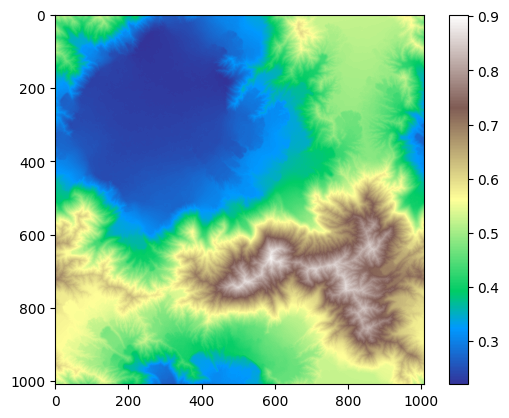

In [6]:
plt.imshow(terrain, cmap="terrain")
plt.colorbar()
plt.show()